In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error


### 3. Load and Prepare Data
Load your dataset and prepare it for the LSTM model. This involves parsing dates, normalizing the 'Page.Loads' data, and creating sequences for the LSTM.

In [6]:
# Load dataset
data = pd.read_csv('data.csv', parse_dates=['Date'], index_col='Date')

data['Page.Loads'] = data['Page.Loads'].str.replace(',', '').astype(int)

data.drop(columns="Row",inplace=True)
data.drop(columns="Day",inplace=True)
data.drop(columns="Day.Of.Week",inplace=True)
data.drop(columns="Unique.Visits",inplace=True)
data.drop(columns="Returning.Visits",inplace=True)
data.drop(columns="First.Time.Visits",inplace=True)

# Display the first few rows of the dataset
print(data.head())




# Normalize the 'Page.Loads' data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Page.Loads'] = scaler.fit_transform(data[['Page.Loads']].values.reshape(-1, 1))


# Function to create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

# Define the window size
window_size = 5

# Create sequences
X, y = create_sequences(data['Page.Loads'].values.reshape(-1, 1), window_size)

# Reshape X for LSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)


            Page.Loads
Date                  
2014-09-14        2146
2014-09-15        3621
2014-09-16        3698
2014-09-17        3667
2014-09-18        3316


## 4. Build the LSTM Model
Define and compile the LSTM model with TensorFlow/Keras.

In [7]:
# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()


c:\Users\sebron2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - val_loss: 0.0061
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - val_loss: 0.0065
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 - val_loss: 0.0057
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 12/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039 - val_lo

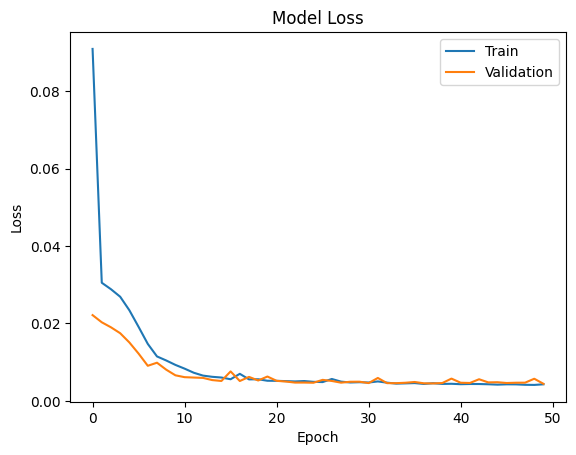

In [9]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


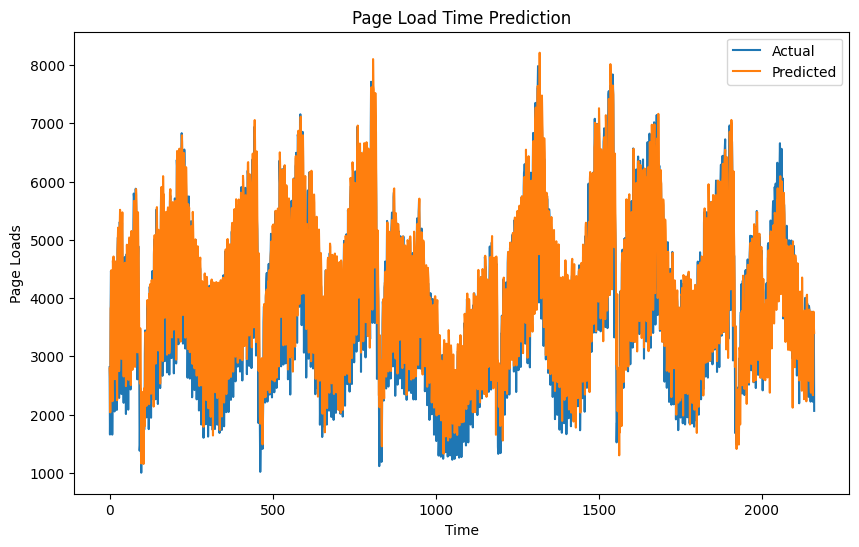

In [10]:
# Forecasting
predicted = model.predict(X)
predicted = scaler.inverse_transform(predicted)

# Inverse original transformation
original_y = scaler.inverse_transform(y.reshape(-1, 1))

# Plot original vs predicted
plt.figure(figsize=(10,6))
plt.plot(original_y, label='Actual')
plt.plot(predicted, label='Predicted')
plt.title('Page Load Time Prediction')
plt.xlabel('Time')
plt.ylabel('Page Loads')
plt.legend()
plt.show()
